In [20]:
import matplotlib.pyplot as plt
import csv
import sys
sys.path.insert(1, '/home/kirant/thinglap/NSHM-projects/distr-seismicity-models')

### Determine if a given point (lon, lat, dep) is within slab or interface. 


The idea would be:  <br/>
(1) is depth is surely curstal?  <br/>
(1) Is longitude and latitude within bounds of subduction zone,  <br/>
(2) If so, is the depth wthin slab, and if not, interface 

<IPython.core.display.Javascript object>


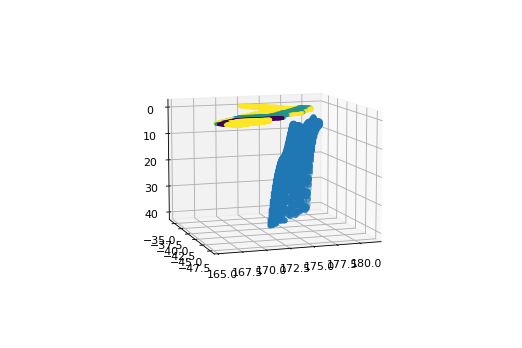

In [15]:
# def iswithinslab(lat, lon, dep, slabmodel=None)
# def iswithininterface(lat, lon, dep, interfacemodel=None)

%matplotlib notebook

interface_model = '../subduction/hikinterfacegrid.csv'

slon, slat, sdep = ([],[],[])

depth_cutoff = 40

with open(interface_model, 'r') as file:
    csvreader = csv.reader(file)
    header = next(csvreader)
    header = next(csvreader)
    for row in csvreader:
        if (float(row[2])< depth_cutoff):
            slon.append(float(row[0]))
            slat.append(float(row[1]))
            sdep.append(float(row[2]))
buffer = [5,5] # [buffer_above, buffer_below]

fig = plt.figure()
#fig.set_size_inches(10,10)
ax = plt.axes(projection='3d')
ax.scatter3D(slon, slat, sdep);

ax.invert_zaxis()
plt.show()

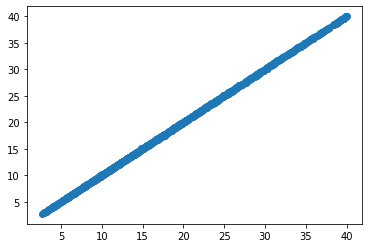

In [8]:
%matplotlib inline
from scipy.interpolate import interp2d
import numpy as np

fintp = interp2d(np.array(slon), np.array(slat), np.array(sdep), kind='linear')
pdep = []
for a,b in zip(slon, slat):
    d = fintp(a,b)
    pdep.append(d[0])
    
plt.plot(sdep, pdep, 'o');

In [45]:
from scipy.interpolate import interp2d
import numpy as np
import kpolygon.polygon as poly

def interface_depth_function(interface_model=None):
    if interface_model is None:
        interface_model = '../subduction/hikinterfacegrid.csv'

    depth_cutoff = 40
    
    slon, slat, sdep = ([],[],[])
    with open(interface_model, 'r') as file:
        csvreader = csv.reader(file)
        header = next(csvreader)
        header = next(csvreader)
        for row in csvreader:
            if (float(row[2])< depth_cutoff):
                slon.append(float(row[0]))
                slat.append(float(row[1]))
                sdep.append(float(row[2]))
            
    fintp = interp2d(np.array(slon), np.array(slat), np.array(sdep), kind='linear')
    blon, blat = poly.boundary(slon, slat)
    return(fintp, (blon, blat))


In [37]:

interface_model = '../subduction/hikinterfacegrid.csv'
fintp_hik = interface_depth_function(interface_model=interface_model)
interface_model = '../subduction/puyinterfacegrid.csv'
fintp_puy = interface_depth_function(interface_model=interface_model)


def check4subductions(lon, lat, dep, 
            interface_buffer=None, interface_model = None):
    # return is_interface, is_slab

    if interface_buffer is None:
        interface_buffer = [5,5] # [buffer_above, buffer_below]
    
    if interface_model is None:
        hik_model = '../subduction/hikinterfacegrid.csv'
        fintp_hik = interface_depth_function(interface_model=hik_model)
        puy_model = '../subduction/puyinterfacegrid.csv'
        fintp_puy = interface_depth_function(interface_model=puy_model)
        interface_model = (finp_hik, fintp_puy)
    
    finp_hik, fintp_puy = interface_model
    # check for hik
    is_interface, is_slab = is_withinsubduction(lon, lat, dep, interface_buffer, finp_hik)
    
    # check for puy
    if (not is_interface) & (not is_slab):
         is_interface, is_slab = is_withinsubduction(lon, lat, dep, interface_buffer, fintp_puy)
    
    return is_interface, is_slab

def is_withinsubduction(lon, lat, dep, interface_buffer, interface_function):
    # interface_function is interpolation accross interface
    # to allow estimate the depth
    pdep = interface_function(lon, lat)
    if pdep==0:
        return False, False
    elif (dep>=(pdep-interface_buffer[0])) & (dep<=(pdep+interface_buffer[1])):
        return True, False
    elif dep>(pdep+interface_buffer[1]):
        return False, True
    else:
        return False, False
    



<IPython.core.display.Javascript object>


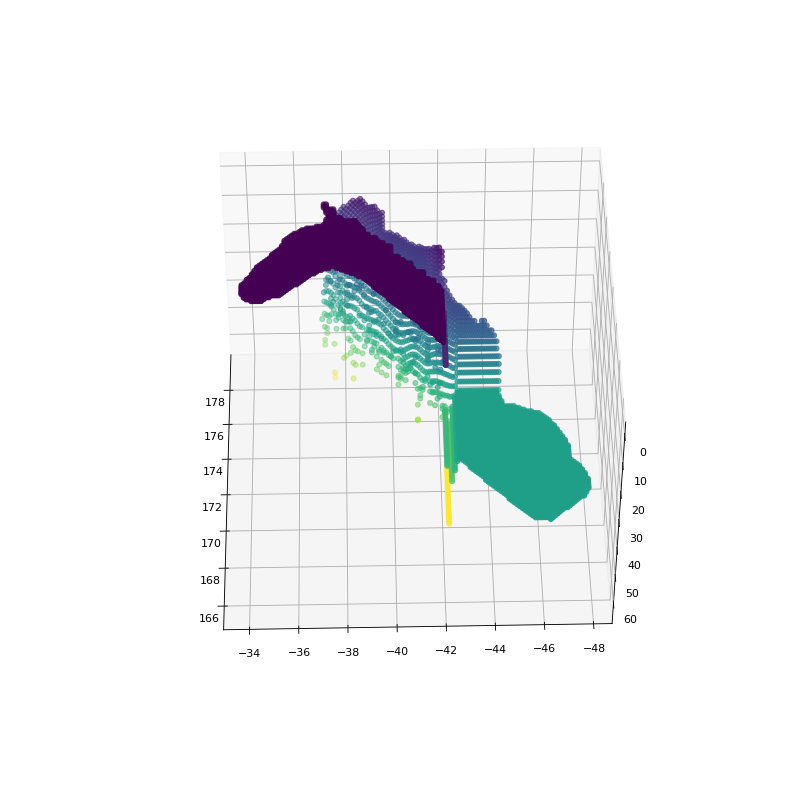

In [58]:
import grids.grids as grids
glon, glat = grids.get_sample_grid(file = '../grids/samplegrid.txt')
gdep= [15]*len(glon)

hik_model = '../subduction/hikinterfacegrid.csv'
fintp_hik, hik_lonlat = interface_depth_function(interface_model=hik_model)
puy_model = '../subduction/puyinterfacegrid.csv'
fintp_puy, puy_lonlat = interface_depth_function(interface_model=puy_model)
interface_model = (fintp_hik, fintp_puy)

deps = []
for i in range(len(glon)):
    #   
    pdep1 = fintp_hik(glon[i], glat[i])
    deps.append(pdep1)
    """
    if pdep1>0.0:
        deps.append(pdep1)
    else:
        deps.append(0)
        #pdep2 = fintp_puy(glon[i], glat[i])
        #deps.append(pdep2)
    """
   

%matplotlib notebook
"""
fig = plt.figure()
fig.set_size_inches(10,10)
plt.scatter(glon, glat, s=5,c= deps);
lon,lat = hik_lonlat
plt.plot(lon, lat, 'o')
lon,lat = puy_lonlat
plt.plot(lon, lat, 'o')
plt.colorbar();
"""
fig = plt.figure()
fig.set_size_inches(10,10)
ax = plt.axes(projection='3d')


ax.scatter3D(glon, glat, deps, c= deps);
ax.invert_zaxis()

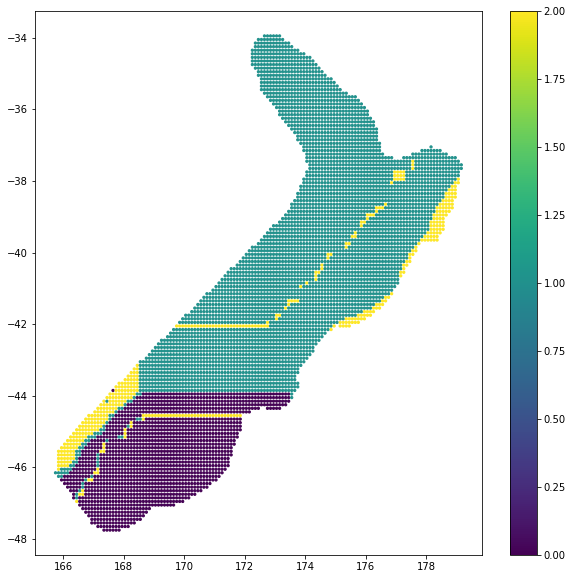

In [39]:
import grids.grids as grids
glon, glat = grids.get_sample_grid(file = '../grids/samplegrid.txt')
gdep= [15]*len(glon)

hik_model = '../subduction/hikinterfacegrid.csv'
fintp_hik = interface_depth_function(interface_model=hik_model)
puy_model = '../subduction/puyinterfacegrid.csv'
fintp_puy = interface_depth_function(interface_model=puy_model)
interface_model = (fintp_hik, fintp_puy)

regime = []

for i in range(len(glon)):
    #   
    is_interface, is_slab = check4subductions(glon[i], glat[i], gdep[i], 
            interface_buffer=[5,5], interface_model = interface_model)
    if is_interface:
        regime.append(1)
    elif is_slab:
        regime.append(2)
    else:
        regime.append(0)

%matplotlib inline
fig = plt.figure()
fig.set_size_inches(10,10)
plt.scatter(glon, glat, s=5,c= regime);

plt.colorbar()
    
    